### Import Libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report
)
from sklearn.tree import plot_tree

### Import and Split Dataset

In [93]:
df = pd.read_csv('..\\data\\clean\\ordinal_encoded.csv')

X = df.drop('class_value', axis=1)
y = df['class_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_names = ['Unacceptable', 'Acceptable', 'Good', 'Very Good']
feature_names = X.columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### General Purpose Methods

In [94]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive model evaluation
    """
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Print performance metrics
    print(f"\n{model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(10,7))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Return both metrics and the model
    return {
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        },
        'model': model
    }

In [95]:
def plot_feature_importance(model, feature_names, model_name):
    plt.figure(figsize=(12,6))
    
    # Different importance extraction for different model types
    if isinstance(model, LogisticRegression):
        # For Logistic Regression, use absolute coefficient values
        importances = np.abs(model.coef_).mean(axis=0)
    elif isinstance(model, DecisionTreeClassifier):
        # For Decision Tree, use built-in feature importance
        importances = model.feature_importances_
    
    # Create feature importance plot
    indices = np.argsort(importances)
    plt.title(f'{model_name} - Feature Importances')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

## Logistic Regression

Logistic Regression Analysis:

Logistic Regression Model Performance:
Accuracy: 0.8382
Precision (Macro): 0.7218
Recall (Macro): 0.6377
F1 Score (Macro): 0.6727

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.72      0.55      0.62        77
  Acceptable       0.58      0.50      0.54        14
        Good       0.88      0.97      0.92       242
   Very Good       0.70      0.54      0.61        13

    accuracy                           0.84       346
   macro avg       0.72      0.64      0.67       346
weighted avg       0.83      0.84      0.83       346



c:\Users\gatz0\Desktop\Projects\car-value-score-prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


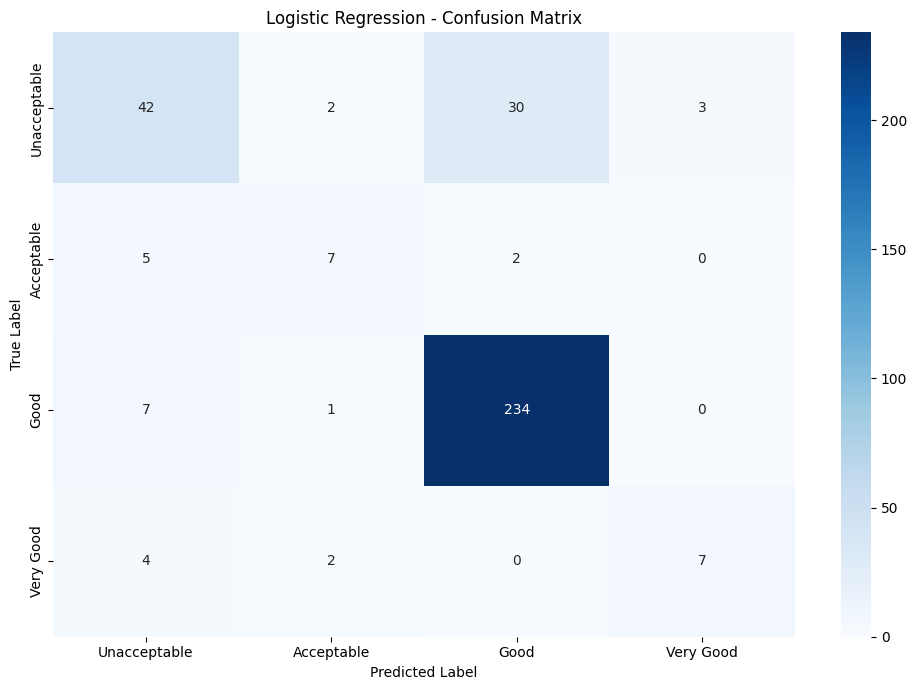

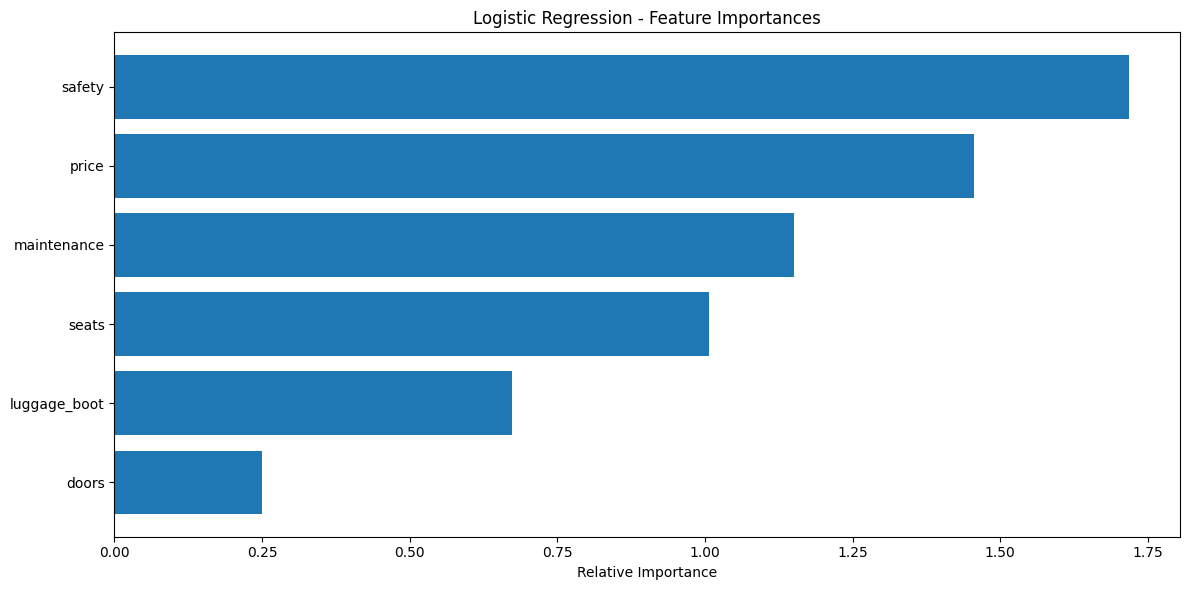

In [96]:
# Train Logistic Regression Model
lr_model = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs',
    max_iter=1000
)
lr_model.fit(X_train_scaled, y_train)

# Evaluate Logistic Regression
print("Logistic Regression Analysis:")
lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test, 'Logistic Regression')

# Plot Logistic Regression Feature Importance
plot_feature_importance(lr_model, feature_names, 'Logistic Regression')

## Decision Tree


Decision Tree Analysis:

Decision Tree Model Performance:
Accuracy: 0.8699
Precision (Macro): 0.5558
Recall (Macro): 0.6098
F1 Score (Macro): 0.5806

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.72      0.79      0.75        77
  Acceptable       0.00      0.00      0.00        14
        Good       0.94      0.95      0.95       242
   Very Good       0.56      0.69      0.62        13

    accuracy                           0.87       346
   macro avg       0.56      0.61      0.58       346
weighted avg       0.84      0.87      0.85       346



c:\Users\gatz0\Desktop\Projects\car-value-score-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gatz0\Desktop\Projects\car-value-score-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gatz0\Desktop\Projects\car-value-score-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

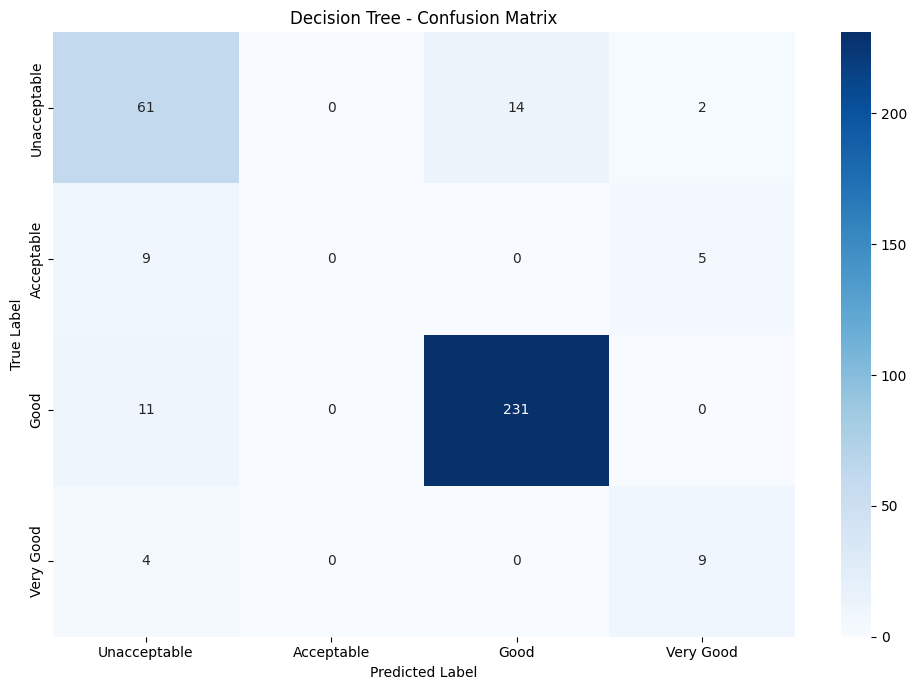

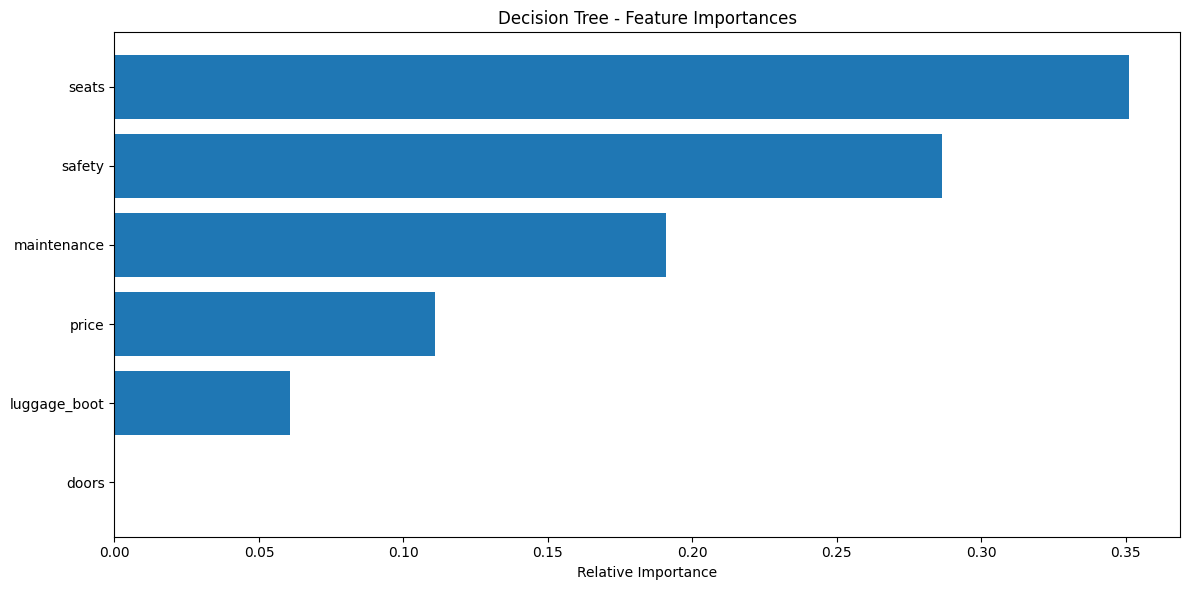

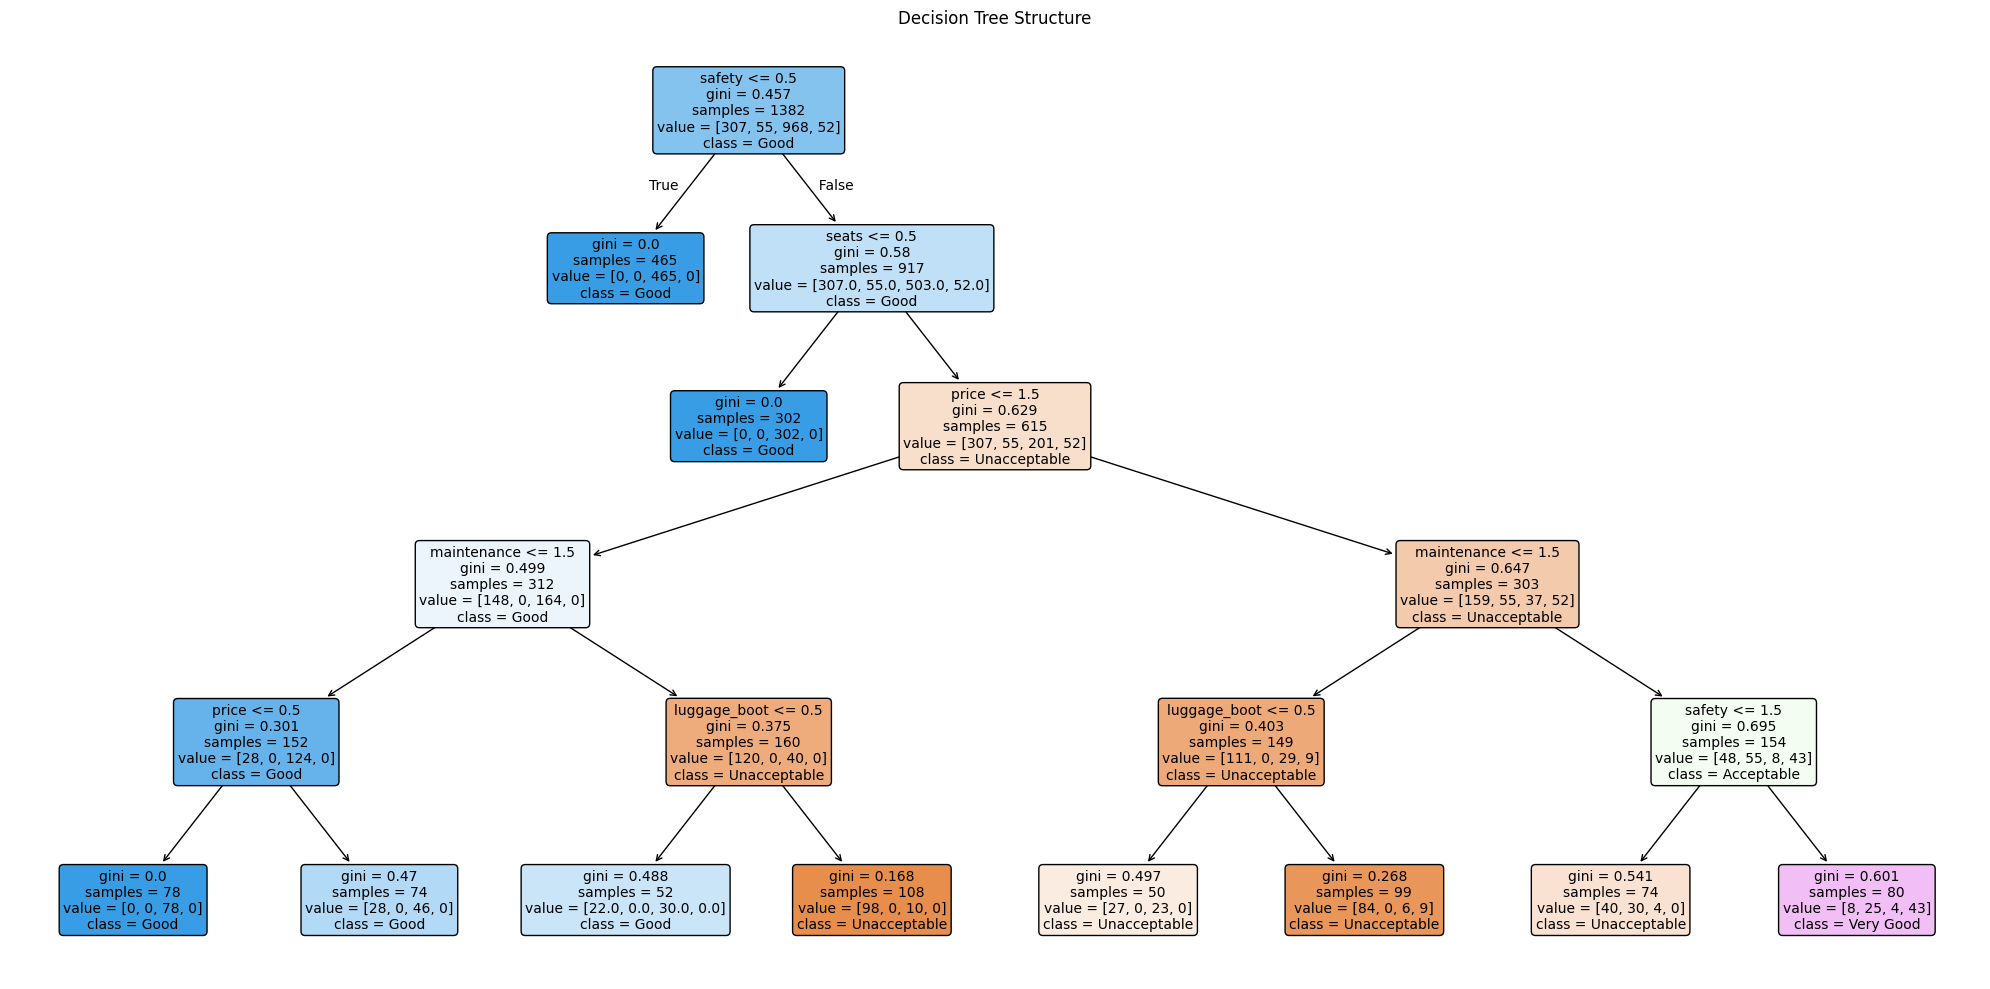

In [97]:
# Train Decision Tree Model
dt_model = DecisionTreeClassifier(
    random_state=42, 
    max_depth=5  # Prevent overfitting
)
dt_model.fit(X_train, y_train)

# Evaluate Decision Tree
print("\nDecision Tree Analysis:")
dt_metrics = evaluate_model(dt_model, X_test, y_test, 'Decision Tree')

# Plot Decision Tree Feature Importance
plot_feature_importance(dt_model, feature_names, 'Decision Tree')

# Visualize Decision Tree Structure
plt.figure(figsize=(20,10))
plot_tree(
    dt_model, 
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True, 
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Structure')
plt.tight_layout()
plt.show()

## Random Forest


Random Forest Model Performance:
Accuracy: 0.9046
Precision (Macro): 0.6751
Recall (Macro): 0.6239
F1 Score (Macro): 0.6356

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.73      0.91      0.81        77
  Acceptable       0.00      0.00      0.00        14
        Good       0.97      0.97      0.97       242
   Very Good       1.00      0.62      0.76        13

    accuracy                           0.90       346
   macro avg       0.68      0.62      0.64       346
weighted avg       0.88      0.90      0.89       346



c:\Users\gatz0\Desktop\Projects\car-value-score-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gatz0\Desktop\Projects\car-value-score-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gatz0\Desktop\Projects\car-value-score-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

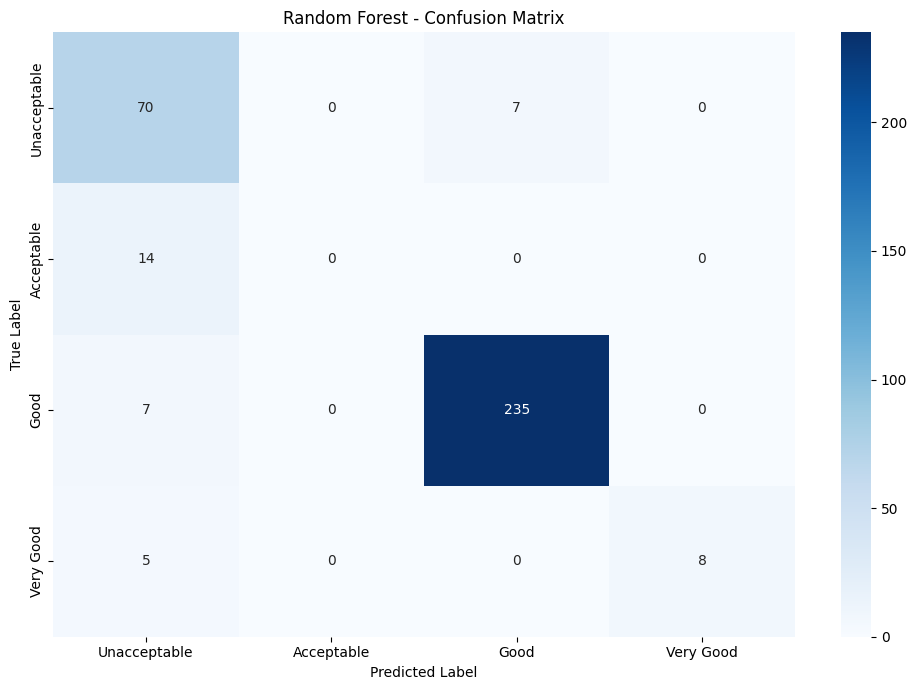

UnboundLocalError: cannot access local variable 'importances' where it is not associated with a value

<Figure size 1200x600 with 0 Axes>

In [98]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5
)
rf_model.fit(X_train, y_train)

# Evaluate the model and get results
rf_result = evaluate_model(rf_model, X_test, y_test, 'Random Forest')

# Plot feature importance
plot_feature_importance(rf_result['model'], feature_names, 'Random Forest')

# Visualize a single tree (optional)
plt.figure(figsize=(20,10))
plot_tree(
    rf_model['model'].estimators_[0],  # First tree in the forest 
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True, 
    rounded=True,
    fontsize=10
)
plt.title('First Tree in Random Forest')
plt.tight_layout()
plt.show()

# Print metrics
print("\nRandom Forest Metrics:")
for metric, value in rf_result['metrics'].items():
    print(f"{metric.capitalize()}: {value:.4f}")




## KNN


Decision Tree Analysis:

Decision Tree Model Performance:
Accuracy: 0.9538
Precision (Macro): 0.9370
Recall (Macro): 0.8191
F1 Score (Macro): 0.8653

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.88      0.95      0.91        77
  Acceptable       0.89      0.57      0.70        14
        Good       0.98      0.99      0.98       242
   Very Good       1.00      0.77      0.87        13

    accuracy                           0.95       346
   macro avg       0.94      0.82      0.87       346
weighted avg       0.95      0.95      0.95       346



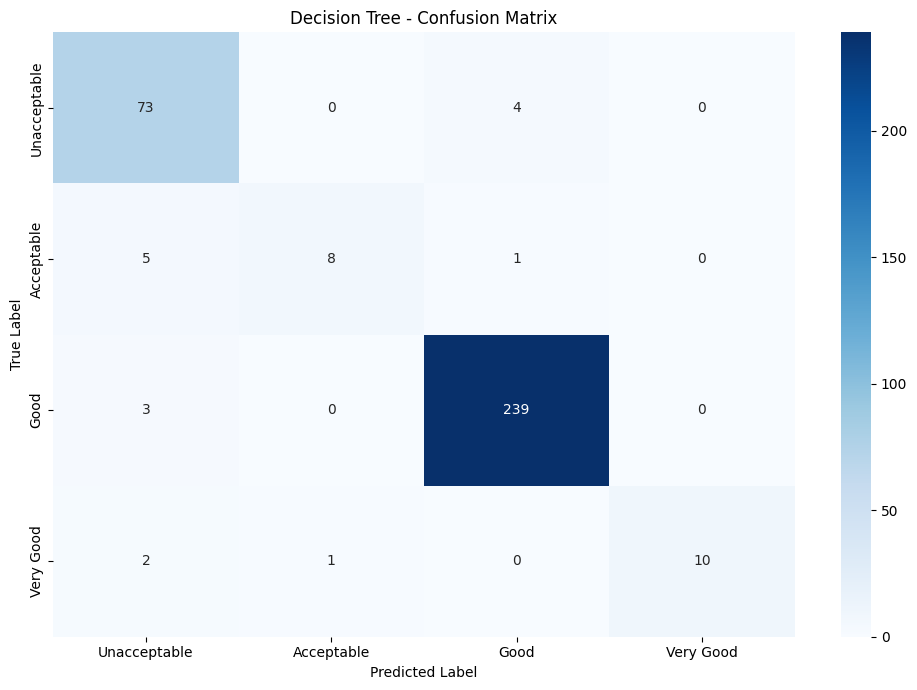

UnboundLocalError: cannot access local variable 'importances' where it is not associated with a value

<Figure size 1200x600 with 0 Axes>

In [ ]:
# {
#     'name': 'K-Nearest Neighbors',
#     'model': KNeighborsClassifier(n_neighbors=5),
#     'X_train': X_train_scaled,
#     'X_test': X_test_scaled
# }

# Train Decision Tree Model
knn_model = KNeighborsClassifier(
    n_neighbors=5
)
knn_model.fit(X_train_scaled, y_train)

# Evaluate Decision Tree
print("\nDecision Tree Analysis:")
knn_metrics = evaluate_model(knn_model, X_test_scaled, y_test, 'Decision Tree')

# Plot Decision Tree Feature Importance
plot_feature_importance(knn_model, feature_names, 'Decision Tree')

# Visualize Decision Tree Structure
plt.figure(figsize=(20,10))
plot_tree(
    knn_metrics, 
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True, 
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Structure')
plt.tight_layout()
plt.show()